In [1]:
__author__ = 'Alice Jacques <alice.jacques@noirlab.edu>, NOIRLab Astro Data Lab Team <datalab@noirlab.edu>' 
__version__ = '20210106' 
__datasets__ = ['ls_dr8','sdss_dr16','gaia_dr2','des_dr1','smash_dr2','unwise_dr1','allwise'] 
__keywords__ = ['crossmatch','joint query','mydb','vospace','image cutout']

# How to use the pre-crossmatched tables at Astro Data Lab

by Alice Jacques and the NOIRLab Astro Data Lab Team

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Accessing the pre-crossmatched tables](#access)
* [Writing a JOIN query](#joinquery)
* [Joint query of LS and SDSS catalogs](#lssdss)
* [Crossmatch a user-provided table and a pre-crossmatched table](#usertable)
* [Speed test](#speedtest)
* [Appendix](#appendix)
* [Resources & references](#refs)

<a class="anchor" id="goals"></a>
# Goals

* Learn how to use a pre-crossmatched table to do a joint query on two Data Lab data sets
* Learn how to do an efficient crossmatch of a user-provided data table against a Data Lab pre-crossmatched table

# Summary

#### Crossmatch table naming template
The crossmatch tables at Astro Data Lab are named as follows:

`schema1.xNpN__table1__schema2__table2`

where the N in NpN encode the numerical value of the crossmatching radius (since dots '.' are not allowed in table names).

Example: 

`ls_dr8.x1p5__tractor_primary_n__gaia_dr2__gaia_source`

is a crossmatch table (indicated by the leading x), located in the ls_dr8 schema, and it crossmatches the **ls_dr8.tractor_primary_n** table with the **gaia_dr2.gaia_source** table (which lives in the gaia_dr2 schema) within a 1.5 arcseconds radius ('1p5') .

This is admittedly long, but clean, consistent, and most importantly, parsable. The use of double-underscores '\__' is to distinguish from single underscores often used in schema and table names.


#### Columns in crossmatch tables
All crossmatch tables shall be minimalist, i.e. have only these columns: id1,ra1,dec1,id2,ra2,dec2,distance.
Column descriptions in the crossmatch table shall contain the original column names in parentheses (makes it parsable).

For example:

`ls_dr8.x1p5__tractor_primary_n__gaia_dr2__gaia_source`

| Column   | Description                                     | Datatype |
|----------|-------------------------------------------------|----------|
| id1      | ID in left/first table (ls_id)                  | BIGINT   |
| ra1      | Right ascension in left/first table (ra)        | DOUBLE   |
| dec1     | Declination in left/first table (dec)           | DOUBLE   |
| id2      | ID in right/second table (source_id)            | BIGINT   |
| ra2      | Right ascension in right/second table (ra)      | DOUBLE   |
| dec2     | Declination in right/second table (dec)         | DOUBLE   |
| distance | Distance between ra1,dec1 and ra2,dec2 (arcsec) | DOUBLE   |


#### Datatypes in crossmatch tables

* The column data types in a crossmatch table for columns id1 and id2 shall be retained from the mother tables. The example above, BIGINT, is valid in many cases, but need not be for all data sets.
* The data types for columns ra1, dec1, ra2, dec2 shall be DOUBLE, which they usually will be anyway.
* The column distance can be either REAL or DOUBLE.

#### Overview

* **The following 5 data sets are considered the main reference tables** and are crossmatched against all data sets (if there is sky overlap) and when a new data set is ingested:  
    - latest gaia_drN.gaia_source    
    - latest nsc_drN.object
    - latest unwise_drN.object
    - allwise.source  
    - latest sdss_drN.specobj
* **"Crossmatch" means for now "single nearest neighbor"** (and this is the current mode at Data Lab).
* **Object tables only**, not single epoch measurements or metadata tables.
* For every crossmatch table with table1 as the left/first table and table2 as the right/second table, there exists a corresponding crossmatch table with table2 as the left/first table and table1 as the right/second table. 
    - For example, `allwise.x1p5__source__des_dr1__main` and `des_dr1.x1p5__main__allwise__source`.


The list of available crossmatch tables can be viewed on our query interface [here](https://datalab.noirlab.edu/query.php) under their respective schema.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass

# 3rd party
from astropy.utils.data import download_file  #import file from URL
from matplotlib.ticker import NullFormatter
import pylab as plt
import matplotlib
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert # converts table to Pandas dataframe object

<a class="anchor" id="auth"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, issue this command, and respond according to the instructions:

In [3]:
#ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'demo00'

<a class="anchor" id="access"></a>
# Accessing the pre-crossmatched tables 
We can use Data Lab's Query Client to access the pre-crossmatched tables hosted by Data Lab. First let's get a total count of the number of objects (nrows) in SDSS DR16 that are also in LS DR8:

In [4]:
%%time
query="SELECT nrows FROM tbl_stat WHERE schema='sdss_dr16' and tbl_name='x1p5__specobj__ls_dr8__tractor_primary'"

# Call query manager
response = qc.query(sql=query)
print(response)

nrows
4542857

CPU times: user 25.7 ms, sys: 4.94 ms, total: 30.7 ms
Wall time: 100 ms


Now let's print just the first 100 rows:

In [5]:
query = "SELECT * FROM sdss_dr16.x1p5__specobj__ls_dr8__tractor_primary LIMIT 100"
response = qc.query(sql=query)
result = convert(response) # convert the table into a Pandas dataframe object
result

id1        ra1       dec1               id2         ra2  \
0   3384465917919389696  287.22826  48.064735  8797230351783516  287.228165   
1   3384466192797296640  287.44889  48.229698  8797230414957399  287.448870   
2   3384462344506599424  287.38750  48.168965  8797230414890143  287.387517   
3   3384463718896134144  287.69779  48.382804  8797230477803600  287.697861   
4   3384465093285668864  287.54718  48.407654  8797230477804882  287.547174   
..                  ...        ...        ...               ...         ...   
95  3384471690355435520  287.70990  48.888661  8797230602453456  287.709937   
96  3384469491332179968  287.66389  48.944252  8797230602454731  287.663800   
97  3384480486448457728  287.22115  48.827232  8797230540199804  287.221105   
98  3384477737669388288  287.29420  48.927487  8797230602388155  287.294186   
99  3384470590843807744  287.46812  49.027895  8797230602391658  287.468139   

         dec2  distance  
0   48.064735  0.000063  
1   48.229697  0.000014  
2   48.168933  0.000034  
3   48.382752  0.000070  
4   48.407548  0.000106  
..        ...       ...  
95  48.888637  0.000034  
96  48.944491  0.000247  
97  48.827183  0.000057  
98  48.927487  0.000009  
99  49.027900  0.000013  

[100 rows x 7 columns]

<a class="anchor" id="joinquery"></a>
# Writing a JOIN query
In order to extract only the relevant columns pertaining to our science question from multiple data tables, we may write a query that uses a JOIN statement. There are 4 main types of JOIN statements that we could use, and which one we decide to choose depends on how we want the information to be extracted. 
1. **(INNER) JOIN**: Returns rows that have matching values in both tables
2. **LEFT (OUTER) JOIN**: Returns all rows from the left table, and the matched rows from the right table
3. **RIGHT (OUTER) JOIN**: Returns all rows from the right table, and the matched rows from the left table
4. **FULL (OUTER) JOIN**: Returns all rows when there is a match in either left or right table

Take a moment to look over the figure below outlining the various JOIN statement types.  
NOTE: the default JOIN is an `INNER JOIN`.

<img src='join.png'></img>

### `JOIN LATERAL`

In nearest neighbor crossmatch queries, we use `JOIN LATERAL`, which is like a SQL foreach loop that will iterate over each row in a result set and evaluate a subquery using that row as a parameter.

<a class="anchor" id="lssdss"></a>
# Joint query of LS and SDSS catalogs
Here we will examine spectroscopic redshifts from SDSS DR16 and photometry from LS DR8. The two crossmatch tables related to these two catalogs are: 
`ls_dr8.x1p5__tractor__sdss_dr16__specobj` and `sdss_dr16.x1p5__specobj__ls_dr8__tractor_primary`. The choice of which of these two crossmatch tables to use should be based on the science question being posed. For instance,  the question *'how does a galaxy's structure change with redshift?'* is dependent on the redshift values obtained from SDSS DR16, so we should use the crossmatch table that has SDSS DR16 as the first table. So, the relevant information we want from our 3 tables of interest for this example are:

1. "X" = `sdss_dr16.x1p5__specobj__ls_dr8__tractor_primary`
    - **ra1** (RA of sdss object)
    - **dec1** (Dec of sdss object)
2. "S" = `sdss_dr16.specobj`
    - **z** (redshift)
    - **class** (spectroscopic class: GALAXY, QSO, or STAR)
    - **veldisp** (velocity dispersion)
    - **veldisperr** (error in velocity dispersion)
3. "L" = `ls_dr8.tractor`
    - **ra** (RA of ls object)
    - **dec** (Dec of ls object)
    - **type** (morphological model: PSF=stellar, REX=round exponential galaxy, DEV=deVauc, EXP=exponential, COMP=composite, DUP=Gaia source fit by different model)
    - **g_r** (computed g-r color)
    - **r_z** (computed r-z color)

### Write the query
Now that we know what we want and where we want it from, let's write the query and then print the results on screen. Here we use two join statements: the first will search in the SDSS DR16 `specobj` table for rows that have the same SDSS id value (`specobjid`) as in the pre-crossmatched table (`id1`) and retrieve the desired columns from the SDSS DR16 `specobj` table. The second will search in the LS DR8 `tractor` table for rows that have the same LS id value (`ls_id`) as in the pre-crossmatched table (`id2`) and retrieve the desired columns from the LS DR8 `tractor` table.

In [6]:
query = ("""SELECT 
           X.ra1 as ra_sdss,X.dec1 as dec_sdss,
           S.z,S.class,S.veldisp,S.veldisperr,
           L.ra as ra_ls,L.dec as dec_ls,L.type,L.g_r,L.r_z
         FROM sdss_dr16.x1p5__specobj__ls_dr8__tractor_primary as X 
         JOIN sdss_dr16.specobj as S ON X.id1 = S.specobjid 
         JOIN ls_dr8.tractor AS L ON X.id2 = L.ls_id
         WHERE X.ra1 BETWEEN %s and %s and X.dec1 BETWEEN %s and %s
         """) %(110,200,7.,40.)  #large region
print(query)

SELECT 
           X.ra1 as ra_sdss,X.dec1 as dec_sdss,
           S.z,S.class,S.veldisp,S.veldisperr,
           L.ra as ra_ls,L.dec as dec_ls,L.type,L.g_r,L.r_z
         FROM sdss_dr16.x1p5__specobj__ls_dr8__tractor_primary as X 
         JOIN sdss_dr16.specobj as S ON X.id1 = S.specobjid 
         JOIN ls_dr8.tractor AS L ON X.id2 = L.ls_id
         WHERE X.ra1 BETWEEN 110 and 200 and X.dec1 BETWEEN 7.0 and 40.0
         


In [7]:
%%time
response = qc.query(sql=query) # default format is a CSV file
result = convert(response) # convert to a Pandas dataframe object
result

CPU times: user 2.95 s, sys: 1.34 s, total: 4.29 s
Wall time: 15.5 s


ra_sdss   dec_sdss         z   class  veldisp  veldisperr  \
0        124.50651  39.977437  0.000255    STAR    0.000      0.0000   
1        124.55036  39.957123  0.609857  GALAXY    0.000     37.4020   
2        124.57259  39.949839  0.000254    STAR    0.000      0.0000   
3        124.71343  39.958987  0.000084    STAR    0.000      0.0000   
4        124.59064  39.937906  0.609096  GALAXY  271.814    108.1800   
...            ...        ...       ...     ...      ...         ...   
1122603  145.30634  39.941975  0.991841  GALAXY  850.000     -3.0000   
1122604  145.32186  39.921931  0.840914  GALAXY  225.783     50.1471   
1122605  145.35104  39.911884  0.000115    STAR    0.000      0.0000   
1122606  145.31759  39.889208  0.496421  GALAXY  192.885     87.9772   
1122607  145.20131  39.877223  0.473231  GALAXY  281.237     39.7339   

              ra_ls     dec_ls type       g_r       r_z  
0        124.506504  39.977408  PSF  0.028765 -0.173220  
1        124.550487  39.957111  DEV  1.220370  1.010340  
2        124.572585  39.949822  PSF  0.049299 -0.184618  
3        124.713456  39.958994  PSF  0.911812  0.509768  
4        124.590679  39.937823  EXP  1.670670  1.286990  
...             ...        ...  ...       ...       ...  
1122603  145.306281  39.941974  DEV  1.079630  1.744390  
1122604  145.321819  39.921874  REX  1.972640  1.657430  
1122605  145.351036  39.911868  PSF  0.899591  0.334970  
1122606  145.317538  39.889202  EXP  1.528710  1.178350  
1122607  145.201320  39.877233  DEV  1.901330  1.101480  

[1122608 rows x 11 columns]

### Saving results to VOSpace
VOSpace is a convenient storage space for users to save their work. It can store any data or file type. We can save the results from the same query to our virtual storage space:

In [8]:
response = qc.query(sql=query,fmt='csv',out='vos://testresult.csv')

Let's ensure the file was saved in VOSpace:

In [9]:
sc.ls(name='vos://testresult.csv')

'testresult.csv'

Now let's remove the file we just saved to VOSpace:

In [10]:
sc.rm (name='vos://testresult.csv')

'OK'

Let's ensure the file was removed from VOSpace:

In [11]:
sc.rm (name='vos://testresult.csv')

'A Node does not exist with the requested URI.'

### Saving results to MyDB
MyDB is a useful OS remote per-user relational database that can store data tables. Furthermore, the results of queries can be directly saved to MyDB, as we show in the following example:

In [12]:
response = qc.query(sql=query, fmt='csv', out='mydb://testresult')

Ensure the table has been saved to MyDB by calling the `mydb_list()` function, which will list all tables currently in a user's MyDB:

In [13]:
print(qc.mydb_list(),"\n")

gaia_sample,created:2021-01-06 10:30:09 MST
gaia_sample_xmatch,created:2021-01-06 10:38:16 MST
gals,created:2021-01-06 12:07:28 MST
testresult,created:2021-01-06 12:29:20 MST
 



Now let's drop the table from our MyDB.

In [14]:
qc.mydb_drop('testresult')

'OK'

Ensure it has been removed by calling the `mydb_list()` function again:

In [15]:
print(qc.mydb_list(),"\n")

gaia_sample,created:2021-01-06 10:30:09 MST
gaia_sample_xmatch,created:2021-01-06 10:38:16 MST
gals,created:2021-01-06 12:07:28 MST
 



<a class="anchor" id="usertable"></a>
# Crossmatch a user-provided data table and a pre-crossmatched table
We can construct a query to run a crossmatch in the database using the `q3c_join()` function, which identifies all matching objects within a specified radius in degrees (see details on [using Q3C functions](https://github.com/segasai/q3c)). For this example, we will search only for the single nearest neighbor. For different examples of crossmatching, see our [How to crossmatch tables notebook](https://github.com/noaodatalab/notebooks-latest/blob/master/04_HowTos/CrossmatchTables/How_to_crossmatch_tables.ipynb). 

First, let's query a small selection of sample data from the Data Lab database and store it in MyDB as `gaia_sample`. This will act as our "user-provided table".

In [16]:
query = """SELECT source_id,ra,dec,parallax,pmra,pmdec 
            FROM gaia_dr2.gaia_source 
            WHERE ra<200 AND ra>124 AND random_id<10 
            LIMIT 70000"""
print(query)

SELECT source_id,ra,dec,parallax,pmra,pmdec 
            FROM gaia_dr2.gaia_source 
            WHERE ra<200 AND ra>124 AND random_id<10 
            LIMIT 70000


In [17]:
%%time
response = qc.query(sql=query,out='mydb://gaia_sample',drop=True)

CPU times: user 23.9 ms, sys: 412 µs, total: 24.3 ms
Wall time: 3.29 s


### Write a crossmatch query

Next let's crossmatch our `gaia_sample` table with Data Lab's pre-crossmatched table between SMASH DR2 and allWISE `smash_dr2.x1p5__object__allwise__source`. We'll write our crossmatch query using the `q3c_join()` function as well as the `q3c_dist()` function, searching for the nearest neighbor within a 1.5 arcsec radius (which must be converted into degrees for the query, so we divide by 3600.0). We will then save it in MyDB as `gaia_sample_xmatch`.

In [18]:
%%time
qu = """SELECT
        G.source_id,ss.id1,ss.id2,G.ra,G.dec,ss.ra1,ss.dec1,ss.ra2,ss.dec2,
        (q3c_dist(G.ra,G.dec,ss.ra1,ss.dec1)*3600.0) as dist_arcsec
        FROM mydb://gaia_sample AS G
        JOIN LATERAL (
            SELECT S.id1,S.id2,S.ra1,S.dec1,S.ra2,S.dec2
            FROM 
                smash_dr2.x1p5__object__allwise__source AS S
            WHERE 
                q3c_join(G.ra,G.dec,S.ra1,S.dec1, 1.5/3600.0)
            ORDER BY
                q3c_dist(G.ra,G.dec,S.ra1,S.dec1)
            ASC LIMIT 1
            ) AS ss ON true
    """
resp = qc.query(sql=qu,out='mydb://gaia_sample_xmatch',drop=True)

CPU times: user 29.1 ms, sys: 1.06 ms, total: 30.2 ms
Wall time: 869 ms


We can query the newly created table from MyDB and convert it into a Pandas Dataframe object in order to print it on screen:

In [19]:
query = "SELECT * FROM mydb://gaia_sample_xmatch"
resp = qc.query(sql=query)
result = convert(resp)
result

source_id              id1                  id2          ra  \
0    5205696522501120512   Field80.880606  1482074301351023387  150.869988   
1    5205674807146027008    Field80.61312  1535074301351011624  151.032199   
2    6141410299609363840  Field127.835819  1993039401351059307  199.455692   
3    5467823633613278720   Field85.328869  1577028801351061337  157.482148   
4    5659712743651975424   Field76.497391  1486024301351024709  149.263676   
..                   ...              ...                  ...         ...   
637  5388501192592385536   Field91.325126  1638042501351015781  163.258046   
638  5459798298242774016  Field77.1011912  1493033401351048226  149.796546   
639  6152131053375898496  Field123.257555  1918040901351043838  191.736605   
640  5441173017945297920  Field163.329494  1591037901351024901  159.794886   
641  5390277174450667520  Field165.440845  1661040901351015490  165.908202   

           dec         ra1       dec1         ra2       dec2  dist_arcsec  
0   -74.496170  150.869990 -74.496177  150.869098 -74.496177     0.023617  
1   -74.745129  151.032198 -74.745131  151.032752 -74.745275     0.008880  
2   -38.742563  199.455696 -38.742564  199.455683 -38.742551     0.010309  
3   -28.132586  157.482144 -28.132586  157.482181 -28.132587     0.013867  
4   -24.547096  149.263677 -24.547099  149.263713 -24.547078     0.011663  
..         ...         ...        ...         ...        ...          ...  
637 -42.610578  163.258049 -42.610577  163.258049 -42.610625     0.009637  
638 -33.028633  149.796547 -33.028635  149.796653 -33.028629     0.005438  
639 -40.442602  191.736609 -40.442599  191.736650 -40.442600     0.016839  
640 -38.270692  159.794889 -38.270695  159.794912 -38.270608     0.012900  
641 -41.241788  165.908207 -41.241784  165.908317 -41.241735     0.017132  

[642 rows x 10 columns]

### Write the joint query
Now we can write a query using the JOIN statement in order to extract the columns we want from our tables of interest. Just as in the previous section, let's first make an outline of which tables we'd like to extract columns from.

1. "X" = `mydb://gaia_sample_xmatch`
    - **source_id** (source id from gaia dr2)
    - **id1** (source id from smash dr1) 
    - **id2** (source id from allwise)
    - **ra** (RA value from gaia dr2)
    - **dec** (Dec value from gaia dr2)
2. "s" = `smash_dr2.object`
    - **gmag** (weighted-avarage, calibrated g-band magnitude, 99.99 if no detection)
    - **rmag** (weighted-avarage, calibrated r-band magnitude, 99.99 if no detection)
    - **zmag** (weighted-avarege, calibrated z-band magnitude, 99.99 if no detection)
3. "a" = `allwise.source` 
    - **w1mpro** (W1 magnitude measured with profile-fitting photometry)
    - **w2mpro** (W2 magnitude measured with profile-fitting photometry)
    - **w3mpro** (W3 magnitude measured with profile-fitting photometry)
4. "g" = `mydb://gaia_sample`
    - **parallax**
    - **pmra** (proper motion in right ascension direction)
    - **pmdec** (proper motion in declination direction)
    
    

In [20]:
query = ("""SELECT 
           X.source_id,X.id1,X.id2,X.ra,X.dec,
           s.gmag,s.rmag,s.zmag,
           a.w1mpro,a.w2mpro,a.w3mpro,
           g.parallax,g.pmra,g.pmdec
         FROM mydb://gaia_sample_xmatch as X 
         JOIN smash_dr2.object as s ON X.id1 = s.id 
         JOIN allwise.source AS a ON X.id2 = a.cntr
         JOIN mydb://gaia_sample AS g ON X.source_id = g.source_id
         """)
print(query)

SELECT 
           X.source_id,X.id1,X.id2,X.ra,X.dec,
           s.gmag,s.rmag,s.zmag,
           a.w1mpro,a.w2mpro,a.w3mpro,
           g.parallax,g.pmra,g.pmdec
         FROM mydb://gaia_sample_xmatch as X 
         JOIN smash_dr2.object as s ON X.id1 = s.id 
         JOIN allwise.source AS a ON X.id2 = a.cntr
         JOIN mydb://gaia_sample AS g ON X.source_id = g.source_id
         


In [21]:
response = qc.query(sql=query) # default format is a CSV file
result = convert(response)
result

source_id               id1                  id2          ra  \
0    6131589629253634304  Field168.1156764  1853045501351008859  185.012314   
1    5441239847637128832  Field163.1279533  1587039401351055638  158.835349   
2    5384595418049695616  Field104.1030623  1741039401351048892  174.413163   
3    5199100724044211456   Field87.1011857  1656078801351008164  164.270068   
4    5467597104154887040   Field85.1028867  1577028801351048828  158.070415   
..                   ...               ...                  ...         ...   
107  5198757405832808576   Field87.1204921  1590080301351016502  156.965653   
108  5381961366150238080  Field166.1703433  1727044001351026575  173.588279   
109  5198195207497561088  Field106.1189889  1674080301351024353  170.834267   
110  5458462327193883392  Field161.1718085  1516034901351031680  151.645492   
111  5459798298242774016   Field77.1011912  1493033401351048226  149.796546   

           dec     gmag     rmag     zmag  w1mpro  w2mpro  w3mpro  parallax  \
0   -45.934668  19.4154  18.3814  17.7553  15.931  16.042  13.054  0.158196   
1   -38.680901  20.3020  99.9900  99.9900  15.739  15.543  12.188  1.568020   
2   -39.098332  20.3235  19.4183  18.8627  17.403  17.325  12.088  0.878178   
3   -79.405031  19.8656  18.3270  17.0464  14.755  14.799  12.924  1.008309   
4   -28.561233  20.3464  19.3088  18.7218  17.126  16.309  12.468  0.482538   
..         ...      ...      ...      ...     ...     ...     ...       ...   
107 -80.528784  21.9378  99.9900  99.9900  16.081  15.829  12.932  1.626588   
108 -43.889225  17.9590  99.9900  99.9900  14.997  14.988  12.565  0.604291   
109 -80.526241  18.5196  17.9265  17.5419  16.117  16.245  12.933  0.259513   
110 -34.804156  18.4303  99.9900  99.9900  15.587  15.786  12.449  0.353570   
111 -33.028633  22.3068  20.7488  18.7407  16.427  15.961  12.290  0.869519   

          pmra      pmdec  
0    -9.417819  -4.594620  
1   -13.376750   0.883958  
2    -2.315444  -1.981345  
3    -7.250559   3.201105  
4    -3.713790   0.281505  
..         ...        ...  
107   2.234972 -16.577670  
108  -7.352319  -5.747996  
109  -4.197899  -1.071158  
110  -7.475217   5.853638  
111  -0.222829   2.052986  

[112 rows x 14 columns]

<a class="anchor" id="speedtest"></a>
# Speed test
Here we compare the speed of using the `q3c_join()` function to crossmatch directly in a JOIN query (`query1`) versus using a pre-crossmatched table in a JOIN query (`query2`). We select objects from the two catalogs and retrieve the same specified columns for the two queries. We will see that `query1` times out after 300 seconds (5 minutes) and fails to retrieve results, while `query2` runs for about 60-90 seconds (1-1.5 minutes) and will retrieve the 3.6 million rows we queried for.

#### First, running the crossmatch ourselves:

In [22]:
%%time
query1 = """SELECT
           a.cntr as id1,a.ra as ra1,a.dec as dec1,a.pmdec,a.pmra,a.w1mpro,a.w2mpro,
           gg.specobjid as id2,gg.ra as ra2,gg.dec as dec2,gg.z,gg.class,gg.veldisp,gg.veldisperr,
           (q3c_dist(a.ra,a.dec,gg.ra,gg.dec)*3600.0) as dist_arcsec 
         FROM 
            allwise.source AS a
         INNER JOIN LATERAL (
            SELECT s.specobjid,s.ra,s.dec,s.z,s.class,s.veldisp,s.veldisperr
            FROM 
                sdss_dr16.specobj AS s
            WHERE
                q3c_join(a.ra, a.dec, s.ra, s.dec, 1.5/3600.0)
            ORDER BY
                random()
            ASC LIMIT 1
        ) as gg ON true
"""
resp1 = qc.query(sql=query1,timeout=300)
result1 = convert(resp1)
result1

ReadTimeout: HTTPSConnectionPool(host='datalab.noao.edu', port=443): Read timed out. (read timeout=300)

#### Now, the same but using pre-crossmatched tables:

In [23]:
%%time
query2 = """SELECT 
           X.id1,X.id2,X.ra1,X.dec1,X.ra2,X.dec2,X.distance as dist_arcsec,
           a.pmdec,a.pmra,a.w1mpro,a.w2mpro,
           s.z,s.class,s.veldisp,s.veldisperr
         FROM 
             allwise.x1p5__source__sdss_dr16__specobj as X 
         JOIN 
             allwise.source as a ON X.id1 = a.cntr 
         JOIN 
             sdss_dr16.specobj AS s ON X.id2 = s.specobjid
         """
resp2 = qc.query(sql=query2)
result2 = convert(resp2)
result2

CPU times: user 15 s, sys: 6.24 s, total: 21.2 s
Wall time: 2min 22s


id1                  id2         ra1       dec1  \
0              1601351000041  4902396990288318464    0.609037  -2.119844   
1              1601351000062  4902396440532504576    0.608449  -2.010911   
2              1601351000070  4902398089799946240    0.560765  -2.193133   
3              1601351000092  4902395890776690688    0.647265  -2.032009   
4              1601351000100  4902398914433667072    0.695043  -2.077576   
...                      ...                  ...         ...        ...   
3620144  3584118101351014913  6988603213202345984  357.989353  17.725508   
3620145  3584118101351014916  8555729176824664064  358.236213  17.966856   
3620146  3584118101351014933  6988601838812811264  357.986410  17.949703   
3620147  3584118101351014943  6988592492963975168  358.219032  17.707578   
3620148  3584118101351014977  8555729726580477952  358.078412  17.903960   

                ra2       dec2  dist_arcsec  pmdec    pmra  w1mpro  w2mpro  \
0          0.609022  -2.119838     0.000016 -104.0   373.0  13.899  13.602   
1          0.608431  -2.010910     0.000017  103.0   226.0  14.423  14.137   
2          0.560709  -2.193130     0.000057  355.0   524.0  14.688  14.423   
3          0.647439  -2.031991     0.000175 -150.0  -562.0  15.051  14.778   
4          0.695027  -2.077596     0.000026  -84.0  -462.0  15.104  14.949   
...             ...        ...          ...    ...     ...     ...     ...   
3620144  357.989360  17.725555     0.000048  -25.0   136.0  15.077  14.837   
3620145  358.236200  17.966864     0.000015 -265.0   -78.0  15.254  14.467   
3620146  357.986380  17.949700     0.000029 -130.0  -275.0  15.342  15.299   
3620147  358.219050  17.707563     0.000023 -453.0  -124.0  15.390  15.360   
3620148  358.078430  17.903959     0.000017  556.0  1335.0  15.561  15.580   

                z   class  veldisp  veldisperr  
0        0.198010  GALAXY  290.217     12.5112  
1        0.285261  GALAXY  250.935     15.4101  
2        0.279780  GALAXY  263.838     17.4279  
3        0.383525  GALAXY  179.624     22.3847  
4        0.441733  GALAXY  275.900     27.6191  
...           ...     ...      ...         ...  
3620144  0.333180  GALAXY  262.489     27.4630  
3620145  0.388354     QSO    0.000      0.0000  
3620146  0.536056  GALAXY  241.341     67.2382  
3620147  0.647725  GALAXY  482.677     82.6788  
3620148  0.614666  GALAXY  224.280     62.9146  

[3620149 rows x 15 columns]

### For completeness, we switch the order of the queries and query from a different catalog.
We again select objects from two catalogs and retrieve the same specified columns for two queries. `query3` uses a pre-crossmatched table in a JOIN query and `query4` crossmatches directly in the JOIN query. We will see that `query3` runs for about 60-90 seconds (1-1.5 minutes) and will retrieve the 4.4 million rows we queried for, while `query4` times out after 300 seconds (5 minutes) and fails to retrieve results.

#### First, using pre-crossmatched tables:

In [24]:
%%time
query3 = """SELECT 
           X.id1,X.id2,X.ra1,X.dec1,X.ra2,X.dec2,X.distance as dist_arcsec,
           u.mag_w1_vg,u.mag_w2_vg,s.z,s.class,s.veldisp,s.veldisperr
         FROM 
             unwise_dr1.x1p5__object__sdss_dr16__specobj as X 
         JOIN 
             unwise_dr1.object as u ON X.id1 = u.unwise_objid 
         JOIN 
             sdss_dr16.specobj AS s ON X.id2 = s.specobjid
         ORDER BY 
             random()
         """
resp3 = qc.query(sql=query3,timeout=300)
result3 = convert(resp3)
result3

CPU times: user 18.2 s, sys: 6.48 s, total: 24.7 s
Wall time: 3min 27s


id1                  id2         ra1       dec1  \
0        1816p242o0008345  6720757779777474560  181.396287  23.980743   
1        1921p030o0000058  5354965868882448384  191.467974   2.250147   
2        1542p287o0019720  7275641445331259392  154.735513  29.265876   
3        1736p620o0072039  3747165397556764672  172.155284  62.507245   
4        0302m016o0010965  4896789205991313408   29.939921  -1.533770   
...                   ...                  ...         ...        ...   
4374677  2170p545o0001384 -8986921379960696832  217.024756  53.810269   
4374678  1529p484o0027141  7499641651394269184  153.583747  48.656864   
4374679  1429p318o0021753  2187727479651723264  143.616453  32.459276   
4374680  0045p075o0022367  5108426227812945920    5.069931   8.276791   
4374681  2296p136o0020199  3098642920815749120  228.970485  13.996854   

                ra2       dec2  dist_arcsec  mag_w1_vg  mag_w2_vg         z  \
0        181.396130  23.980645     0.000173    15.7282    15.8485  0.614103   
1        191.467950   2.250242     0.000098    16.0377    15.1628  0.789826   
2        154.735440  29.265926     0.000081    15.3245    15.2035  0.581800   
3        172.155010  62.507550     0.000331    18.0201        inf -0.000967   
4         29.939916  -1.533805     0.000035    15.6155    15.5866  0.531372   
...             ...        ...          ...        ...        ...       ...   
4374677  217.024850  53.810193     0.000094    15.2494    15.3394 -0.000118   
4374678  153.583660  48.656941     0.000096    15.5782    15.3440  0.514003   
4374679  143.616400  32.458967     0.000312    13.4584    13.2668  0.015810   
4374680    5.069878   8.276864     0.000090    16.2602    14.9094  0.891168   
4374681  228.970600  13.996737     0.000162    13.6939    13.6421  0.073585   

          class   veldisp  veldisperr  
0        GALAXY  156.6030    35.57970  
1           QSO    0.0000     0.00000  
2        GALAXY  175.4660    76.06120  
3          STAR    0.0000     0.00000  
4        GALAXY  266.6640    39.24980  
...         ...       ...         ...  
4374677    STAR    0.0000     0.00000  
4374678  GALAXY  222.7310    35.60830  
4374679  GALAXY   39.5004     7.04299  
4374680     QSO    0.0000     0.00000  
4374681  GALAXY  173.2430    11.45080  

[4374682 rows x 13 columns]

#### Now, running the crossmatch ourselves: 

In [25]:
%%time
query4 = """SELECT
           u.unwise_objid as id1,u.ra as ra1,u.dec as dec1,u.mag_w1_vg,u.mag_w2_vg,
           ss.specobjid as id2,ss.ra as ra2,ss.dec as dec2,ss.z,ss.class,ss.veldisp,ss.veldisperr,
           (q3c_dist(u.ra,u.dec,ss.ra,ss.dec)*3600.0) as dist_arcsec 
         FROM 
            unwise_dr1.object AS u
         INNER JOIN LATERAL (
            SELECT s.specobjid,s.ra,s.dec,s.z,s.class,s.veldisp,s.veldisperr
            FROM 
                sdss_dr16.specobj AS s
            WHERE
                q3c_join(u.ra, u.dec, s.ra, s.dec, 1.5/3600.0)
            ORDER BY
                random()
            ASC LIMIT 1
        ) as ss ON true
"""
resp4 = qc.query(sql=query4,timeout=300)
result4 = convert(resp4)
result4

ReadTimeout: HTTPSConnectionPool(host='datalab.noao.edu', port=443): Read timed out. (read timeout=300)

<a class="anchor" id="appendix"></a>
# Appendix

A clear benefit of pre-crossmatched tables is that they contain the positions of the same objects in two datasets. We can use this to e.g. fetch images of an object from both surveys.

## A1. unWISE DR1 vs LS DR8 
Here we will compare two images of the same object from two different catalogs, unWISE DR1 and LS DR8. 

### Function to retrieve cutouts

In [26]:
def make_cutout_comparison_table(ra_in1, dec_in1, layer1, layer2, pixscale, ra_in2=None, dec_in2=None):
    """
    Obtain color JPEG images from Legacy Survey team cutout tool at NERSC
    """    
    img1 = []
    img2 = []
    
    for i in range(len(ra_in1)):
        cutout_url1 = "https://www.legacysurvey.org/viewer/cutout.jpg?ra=%g&dec=%g&layer=%s&pixscale=%s" % (ra_in1[i],dec_in1[i],layer1,pixscale)
        img = plt.imread(download_file(cutout_url1,cache=True,show_progress=False,timeout=120))
        img1.append(img)
        
        cutout_url2 = "https://www.legacysurvey.org/viewer/cutout.jpg?ra=%g&dec=%g&layer=%s&pixscale=%s" % (ra_in2[i],dec_in2[i],layer2,pixscale)
        img = plt.imread(download_file(cutout_url2,cache=True,show_progress=False,timeout=120))
        img2.append(img)

    return img1,img2

### Function to generate plots

In [27]:
def plot_cutouts(img1,img2,cat1,cat2):
    """
    Plot images in two rows with 5 images in each row
    """
    fig = plt.figure(figsize=(21,7))

    for i in range(len(img1)):
        ax = fig.add_subplot(2,6,i+1)
        ax.imshow(img1[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.02,0.93,'ra=%.5f'%list_ra1[i],transform=ax.transAxes,fontsize=12,color='white')
        ax.text(0.02,0.85,'dec=%.5f'%list_dec1[i],transform=ax.transAxes,fontsize=12,color='white')
        ax.text(0.02,0.77,cat1,transform=ax.transAxes,fontsize=12,color='white')

        ax = fig.add_subplot(2,6,i+7)
        ax.imshow(img2[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.02,0.93,'ra=%.5f'%list_ra2[i],transform=ax.transAxes,fontsize=12,color='white')
        ax.text(0.02,0.85,'dec=%.5f'%list_dec2[i],transform=ax.transAxes,fontsize=12,color='white')
        ax.text(0.02,0.77,cat2,transform=ax.transAxes,fontsize=12,color='white')

    plt.subplots_adjust(wspace=0.02, hspace=0.03)

###  Write query to randomly select five targets (RA/Dec positions) from unWISE DR1 and LS DR8 crossmatch table
... then save them as arrays and set the captions, layers, and pixscale. Finally we plot the cutout images.

CPU times: user 1.58 s, sys: 1.14 s, total: 2.71 s
Wall time: 44.6 s


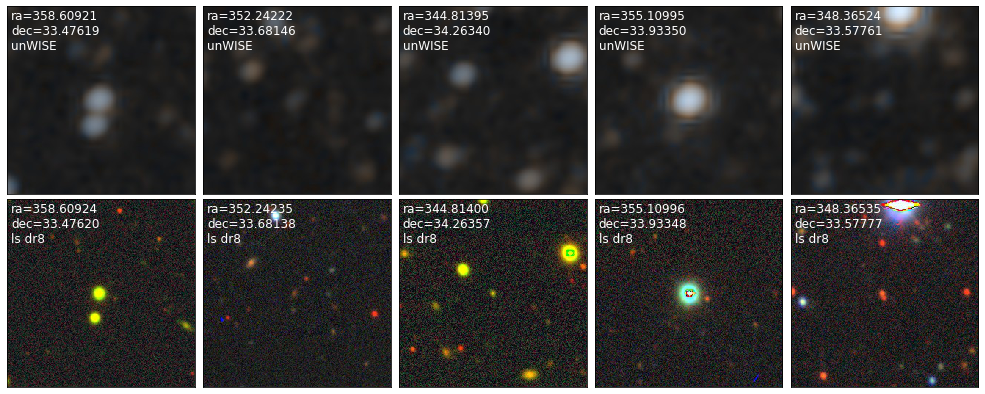

In [28]:
%%time
q = """SELECT ra1,dec1,ra2,dec2 
        FROM unwise_dr1.x1p5__object__ls_dr8__tractor_primary 
        WHERE ra1>300 AND dec1>33 
        ORDER BY random() 
        LIMIT 5"""

r = qc.query(sql=q,fmt='pandas')

list_ra1=r['ra1'].values       # ".values" convert to numpy array
list_dec1=r['dec1'].values
list_ra2=r['ra2'].values       
list_dec2=r['dec2'].values

cat1='unWISE'
cat2='ls dr8'
layer1='unwise-neo6'
layer2='ls-dr8'
pixscale='0.3'
img1,img2 = make_cutout_comparison_table(list_ra1,list_dec1,layer1,layer2,
                                         pixscale,list_ra2,list_dec2)
plot_cutouts(img1,img2,cat1,cat2)

## A2. SDSS vs DES DR1
Here we will compare two images of the same object from two different catalogs, SDSS and DES DR1.

### Write query to randomly select five targets (RA/Dec positions) from SDSS DR16 and DES DR1 crossmatch table
... then save them as arrays and set the captions, layers, and pixscale. Finally we plot the cutout images.

CPU times: user 1.46 s, sys: 1.14 s, total: 2.59 s
Wall time: 16.5 s


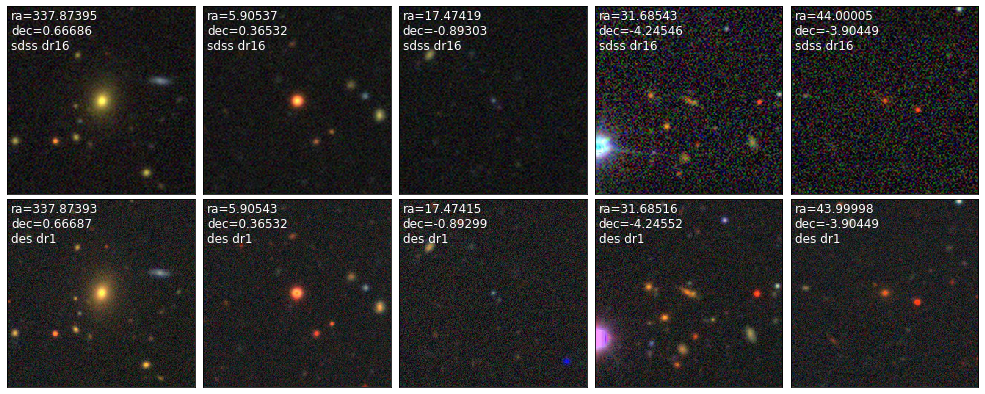

In [29]:
%%time
q = """SELECT ra1,dec1,ra2,dec2 
        FROM sdss_dr16.x1p5__specobj__des_dr1__main 
        ORDER BY random() 
        LIMIT 5"""

r = qc.query(sql=q,fmt='pandas')

list_ra1=r['ra1'].values       # ".values" convert to numpy array
list_dec1=r['dec1'].values
list_ra2=r['ra2'].values       
list_dec2=r['dec2'].values

cat1='sdss dr16'
cat2='des dr1'
layer1='sdss'
layer2='des-dr1'
pixscale='0.25'
img1,img2 = make_cutout_comparison_table(list_ra1,list_dec1,layer1,layer2,
                                         pixscale,list_ra2,list_dec2)
plot_cutouts(img1,img2,cat1,cat2)

## A3. Cool galaxy finds: SDSS vs DES DR1

We compare two images of the same galaxy from two different catalogs, SDSS and DES DR1. We use a list of identified galaxies (RA/Dec positions) to compare the difference in observable features and quality between the two catalogs.

First we import the CSV file of identified galaxies (RA/Dec positions) into MyDB:

In [30]:
qc.mydb_import('gals','./gals.csv',drop=True)

'OK'

We write the query to select the first five RA/Dec positions from our table. We then save them as arrays and set the captions, layers, and pixscale. Finally we plot the cutout images.

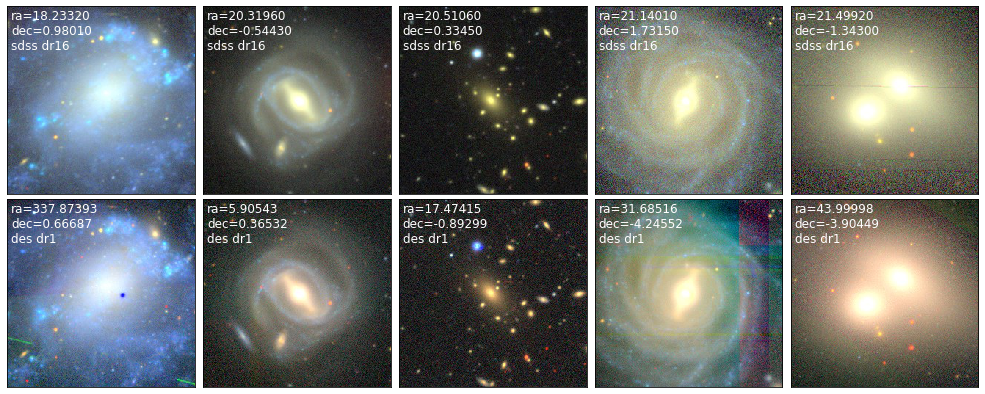

In [31]:
qg = """SELECT ra,dec 
        FROM mydb://gals 
        LIMIT 5"""
rg = qc.query(sql=qg)
rp = convert(rg)
list_ra1=rp['ra'].values       # ".values" convert to numpy array
list_dec1=rp['dec'].values

cat1='sdss dr16'
cat2='des dr1'
layer1='sdss'
layer2='des-dr1'
pixscale='0.5'
img1,img2 = make_cutout_comparison_table(list_ra1,list_dec1,layer1,layer2,
                                        pixscale,ra_in2=list_ra1,dec_in2=list_dec1)
plot_cutouts(img1,img2,cat1,cat2)

We write the next query to select the next five RA/Dec positions from our table. We then save them as arrays and set the captions, layers, and pixscale. Finally we plot the cutout images.

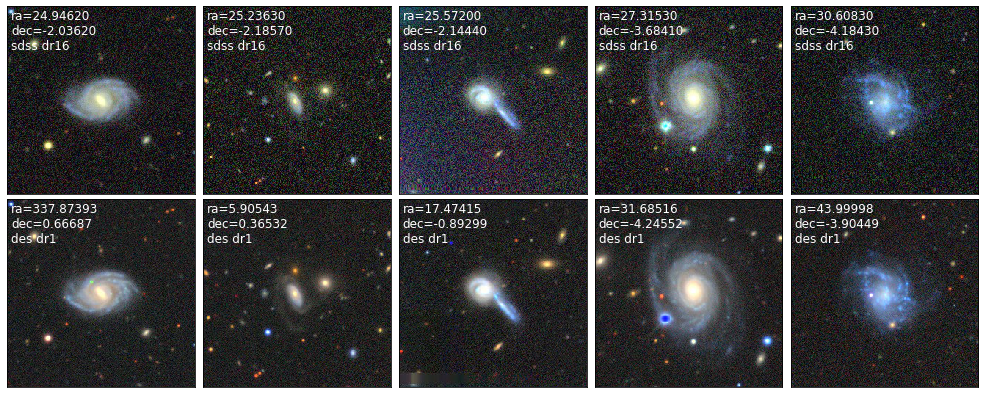

In [32]:
qg = """SELECT ra,dec 
        FROM mydb://gals 
        LIMIT 5 
        OFFSET 5"""
rg = qc.query(sql=qg)
rp = convert(rg)
list_ra1=rp['ra'].values       # ".values" convert to numpy array
list_dec1=rp['dec'].values

img1,img2 = make_cutout_comparison_table(list_ra1,list_dec1,layer1,layer2,
                                        pixscale,ra_in2=list_ra1,dec_in2=list_dec1)
plot_cutouts(img1,img2,cat1,cat2)

We write the next query to select the last five RA/Dec positions from our table. We then save them as arrays and set the captions, layers, and pixscale. Finally we plot the cutout images.

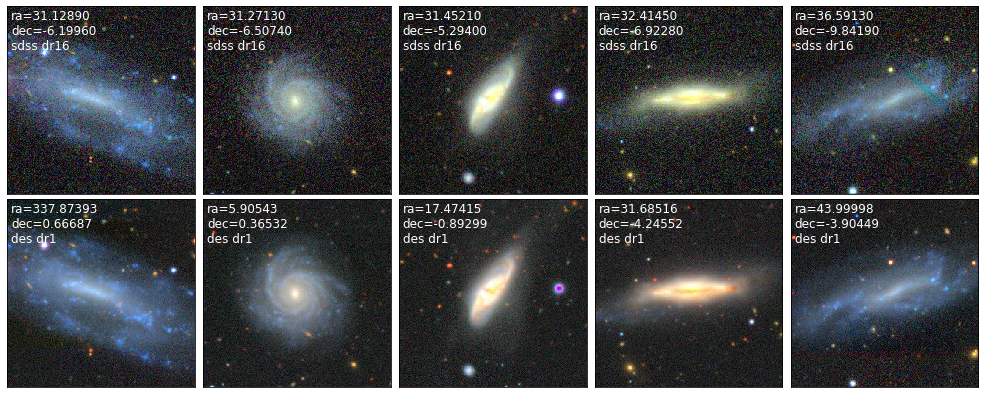

In [33]:
qg = """SELECT ra,dec 
        FROM mydb://gals 
        LIMIT 5 
        OFFSET 10"""
rg = qc.query(sql=qg)
rp = convert(rg)
list_ra1=rp['ra'].values       # ".values" convert to numpy array
list_dec1=rp['dec'].values

img1,img2 = make_cutout_comparison_table(list_ra1,list_dec1,layer1,layer2,
                                        pixscale,ra_in2=list_ra1,dec_in2=list_dec1)
plot_cutouts(img1,img2,cat1,cat2)

<a class="anchor" id="refs"></a>
# Resources & references

W3Schools: SQL Joins https://www.w3schools.com/sql/sql_join.asp  
Legacy Survey Sky Browser: https://www.legacysurvey.org/viewer#NGC%203098